In [592]:
!pip install cesium

In [593]:
#Librerias
import numpy as np
import pandas as pd
from cesium import featurize
import matplotlib.pyplot as plt
import seaborn

# generacion de datos

In [594]:
def generate_sine_dataset(
      n_series=10,
    t_min=0.0,
    t_max=50.0,
    min_length=150,
    max_length=200,
    freq_range=(0.1, 2.0),
    phase_range=(0.0, 2*np.pi),
    amp_range=(0.5, 5.0),
    noise_std=0.05,
    irregular_prob=0.001,
    sample_method='jitter',   # 'random' o 'jitter'
    jitter_scale=0.01,
    seed=643,
    target=0):
    """
    Esta funcion genera dos df de Pandas, uno con las series y otro con metadatos.
      - df_long: DataFrame 'long' con columnas ['series_id', 't', 'value']
      - df_meta: DataFrame con metadatos por serie y la columna 'target' que indica la clase


    """
    rng = np.random.default_rng(seed)
    rows = []
    meta_rows = []

    for sid in range(n_series):
        length = int(rng.integers(min_length, max_length + 1))

        t_start = t_min
        t_end = float(rng.uniform(t_start, t_max))

        is_irregular = bool(rng.random() < irregular_prob)

        if is_irregular:
            if sample_method == 'random':
                t = np.sort(rng.uniform(t_start, t_end, size=length))
            elif sample_method == 'jitter':
                regular = np.linspace(t_start, t_end, length)
                scale = jitter_scale * (t_end - t_start) / max(1, length)
                t = regular + rng.normal(0, scale, size=length)
                t = np.clip(t, t_start, t_end)
                t = np.sort(t)
            else:
                raise ValueError("sample_method debe ser 'random' o 'jitter'")
        else:
            t = np.linspace(t_start, t_end, length)

        freq = float(rng.uniform(freq_range[0], freq_range[1]))
        phase = float(rng.uniform(phase_range[0], phase_range[1]))
        amp = float(rng.uniform(amp_range[0], amp_range[1]))

        noise = rng.normal(0, noise_std, size=length)
        values = amp * np.sin(2 * np.pi * freq * t + phase) + noise

        sid_str = f'series_{sid}'
        for ti, vi in zip(t, values):
            rows.append({
                'series_id': sid_str,
                't': float(ti),
                'value': float(vi)
            })

        meta_rows.append({
            'series_id': sid_str,
            'length': length,
            'amplitude': amp,
            'frequency': freq,
            'phase': phase,
            'is_irregular': is_irregular,
            'target': target
        })

    df_long = pd.DataFrame(rows, columns=['series_id', 't', 'value'])
    df_long['series_id'] = df_long['series_id'].astype(str)
    df_long['t'] = df_long['t'].astype(float)
    df_long['value'] = df_long['value'].astype(float)

    df_meta = pd.DataFrame(meta_rows, columns=['series_id', 'length', 'amplitude', 'frequency', 'phase', 'is_irregular', 'target'])
    df_meta['series_id'] = df_meta['series_id'].astype(str)
    df_meta['length'] = df_meta['length'].astype(int)
    df_meta['amplitude'] = df_meta['amplitude'].astype(float)
    df_meta['frequency'] = df_meta['frequency'].astype(float)
    df_meta['phase'] = df_meta['phase'].astype(float)
    df_meta['is_irregular'] = df_meta['is_irregular'].astype(bool)

    return df_long, df_meta



Generamos 4 clases de datos

In [595]:

runs = [
    {'freq_range': (0.1, 0.11), 'target': 0},
    {'freq_range': (0.6, 0.61),  'target': 1},
    {'freq_range': (1.5, 1.51),  'target': 2},
    {'freq_range': (4, 4.1),  'target': 3},
    {'freq_range': (10, 10.1),  'target': 4},
    {'freq_range': (20, 20.1),  'target': 5},
    {'freq_range': (30, 30.1),  'target': 6},
    {'freq_range': (40, 40.1),  'target': 7},
]

# listas para acumular resultados
series_list = []
meta_list = []

# number of series por llamada (ajusta si quieres)
n_series_per_run = 200

# contador de ID numérico único (comienza en 100)
next_series_id = 100

# bucle: llamar la función 4 veces
for i, cfg in enumerate(runs, start=1):
    # llama a tu función; usa seed distinto si quieres variabilidad
    df_long, df_meta = generate_sine_dataset(
        n_series=n_series_per_run,
        freq_range=cfg['freq_range'],
        seed=42 + i,          # opcional: cambiar seed por run
        target=cfg['target']
    )

    # crear mapping numérico para los series_id de este run
    old_ids = df_meta['series_id'].unique().tolist()  # ej. ['series_0', 'series_1', ...]
    new_ids = list(range(next_series_id, next_series_id + len(old_ids)))
    mapping = dict(zip(old_ids, new_ids))

    # aplicar mapping tanto en df_long como en df_meta
    df_long = df_long.copy()
    df_meta = df_meta.copy()
    df_long['series_id'] = df_long['series_id'].map(mapping).astype(int)
    df_meta['series_id'] = df_meta['series_id'].map(mapping).astype(int)

    # actualizar el contador para la siguiente iteración
    next_series_id += len(old_ids)

    # añadir a las listas
    series_list.append(df_long[['series_id', 't', 'value']])
    meta_list.append(df_meta)  # df_meta ya contiene 'target'

# concatenar todo en dos DataFrames finales
df_all_series = pd.concat(series_list, ignore_index=True)
df_all_meta   = pd.concat(meta_list,   ignore_index=True)

#comprobaciones rápidas
print("df_all_series.shape:", df_all_series.shape)
print("df_all_meta.shape:", df_all_meta.shape)
print("series únicos en meta:", df_all_meta['series_id'].nunique())
print("min/max series_id en meta:", df_all_meta['series_id'].min(), df_all_meta['series_id'].max())

# ver primeras filas
print(df_all_series.head())
print(df_all_meta.head())


df_all_series.shape: (280504, 3)
df_all_meta.shape: (1600, 7)
series únicos en meta: 1600
min/max series_id en meta: 100 1699
   series_id         t     value
0        100  0.000000 -0.785861
1        100  0.012579 -0.787432
2        100  0.025158 -0.847865
3        100  0.037737 -0.758267
4        100  0.050316 -0.783278
   series_id  length  amplitude  frequency     phase  is_irregular  target
0        100     175   1.511174   0.108392  3.689129         False       0
1        101     183   1.138155   0.101158  0.926919         False       0
2        102     153   1.322354   0.107386  5.055675         False       0
3        103     165   2.606931   0.101859  4.319495         False       0
4        104     150   4.758688   0.109544  2.135353         False       0


# Extraccion de Features

In [596]:
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

def extract_features_byCesium(df_all_series,
                              features_to_use=features_to_use,
                              min_points_per_serie=5):

    full_object_list = sorted(df_all_series['series_id'].unique())

    grouped = df_all_series.groupby('series_id')

    time_list = []
    value_list = []
    object_list = []

    for obj_id,g in grouped:
        g = g.sort_values('t')
        if len(g) < min_points_per_serie:
            print(f"Skipping series_id {obj_id} with only {len(g)} points")
            continue

        time_list.append(g['t'].values)
        value_list.append(g['value'].values)
        object_list.append(obj_id)

    if len(object_list) == 0:
        raise ValueError("No series with enough points found.")

    ds = featurize.featurize_time_series(times=time_list,
                                         values=value_list,
                                         features_to_use=features_to_use,
                                         scheduler='threads'
                                         )

    if len(ds) == len(object_list):
        ds.index = object_list

    #ds = ds.reset_index().rename(columns={'index': 'object_id'})


    return ds


In [597]:
#Generamos un df con las features
df_features = extract_features_byCesium(df_all_series,
                                        features_to_use=features_to_use,
                                        min_points_per_serie=5)

In [598]:
#comprobaciones rápidas
print(df_features.shape)
print(df_features.head())
print(df_features.describe())
print(df_features.index)
print(df_features.columns)

(1600, 11)
feature amplitude percent_beyond_1_std   maximum   max_slope    median  \
channel         0                    0         0           0         0   
100      0.433593             0.285714 -0.758267   17.479300 -1.394110   
101      0.162221             0.333333  1.141932  109.054799  0.985963   
102      1.391922             0.496732  1.387237    1.557465 -0.119682   
103      2.727969             0.575758  2.703669    5.868472  0.289343   
104      4.819539             0.500000  4.799678    5.604083 -0.713930   

feature median_absolute_deviation percent_close_to_median   minimum      skew  \
channel                         0                       0         0         0   
100                      0.116881                0.342857 -1.625453  0.948840   
101                      0.039920                0.437158  0.817489 -0.204169   
102                      0.910774                0.143791 -1.396607  0.067574   
103                      2.096044                0.103030 -2.7522

In [599]:
#pasemoslo a .csv
df_features.to_csv("features.csv")

# Gausian Mixture Models

In [600]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA

In [601]:
#Por robustez, reemplazamos NaNs por la mediana de cada feature
feats_imputed = df_features.fillna(df_features.median())
# Normalizamos las features
scaler = StandardScaler()
X = scaler.fit_transform(feats_imputed.values)
print(X.shape)

(1600, 11)


En GMM usamos pca, sin embargo, lo probé sin PCA y no hay diferencias notables

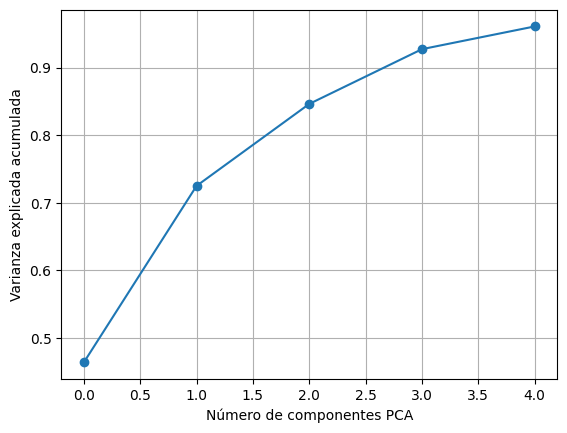

In [602]:
pca = PCA(n_components=0.95, svd_solver='full', random_state=42) #Svd_solver = 'full' es el que mejor resultado da
X_pca = pca.fit_transform(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Número de componentes PCA')
plt.ylabel('Varianza explicada acumulada')
plt.grid(True)
plt.show()

Train: 1280 muestras  |  Test: 320 muestras
Clase 0: log-likelihood medio (train) = -4.90
Clase 1: log-likelihood medio (train) = -1.09
Clase 2: log-likelihood medio (train) = -1.40
Clase 3: log-likelihood medio (train) = -2.60
Clase 4: log-likelihood medio (train) = -3.37
Clase 5: log-likelihood medio (train) = -4.18
Clase 6: log-likelihood medio (train) = -3.97
Clase 7: log-likelihood medio (train) = -3.78

🎯 Precisión en test: 0.3406


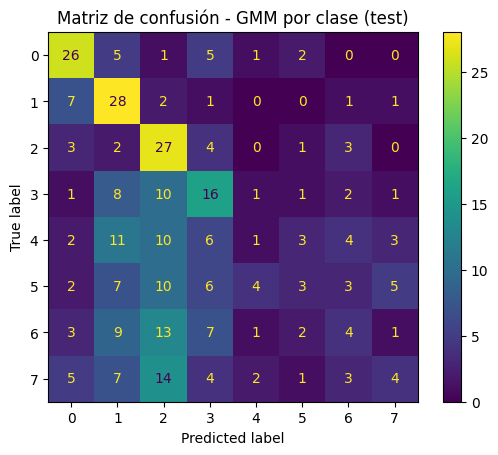

In [603]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# ============================================
# 1️⃣ Preparación de datos
# ============================================

# Asegurar que el índice sea series_id
df_meta_indexed = df_all_meta.set_index('series_id')
# Alinear targets
y = df_meta_indexed.loc[feats_imputed.index, 'target'].to_numpy()

# Ya tenés X_pca calculado
X = X_pca

# División estratificada para mantener la proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} muestras  |  Test: {X_test.shape[0]} muestras")

# ============================================
# 2️⃣ Entrenamiento GMM por clase
# ============================================

gmms = {}
n_components_per_class = 2

for c in np.unique(y_train):
    X_class = X_train[y_train == c]
    gmm = GaussianMixture(
        n_components=n_components_per_class,
        covariance_type='full',
        random_state=42,
        n_init=5
    )
    gmm.fit(X_class)

    train_ll = gmm.score(X_class)
    print(f"Clase {c}: log-likelihood medio (train) = {train_ll:.2f}")

    gmms[c] = gmm

# ============================================
# 3️⃣ Predicción sobre test
# ============================================

# Calculamos la probabilidad (log-likelihood) de cada muestra bajo cada GMM
log_likelihoods = np.zeros((X_test.shape[0], len(gmms)))

for idx, c in enumerate(sorted(gmms.keys())):
    log_likelihoods[:, idx] = gmms[c].score_samples(X_test)

# Elegimos como predicción la clase con mayor log-likelihood
y_pred = np.argmax(log_likelihoods, axis=1)

# ============================================
# 4️⃣ Evaluación
# ============================================

acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Precisión en test: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title("Matriz de confusión - GMM por clase (test)")
plt.show()


In [604]:
# Entrenamiento Gaussian Mixture Model (GMM)
# Probamos con 4 clusters, ya que sabemos que hay 4 clases
n_clusters = 8
gmm = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42, n_init=10)
gmm.fit(X_pca)
labels = gmm.predict(X_pca)

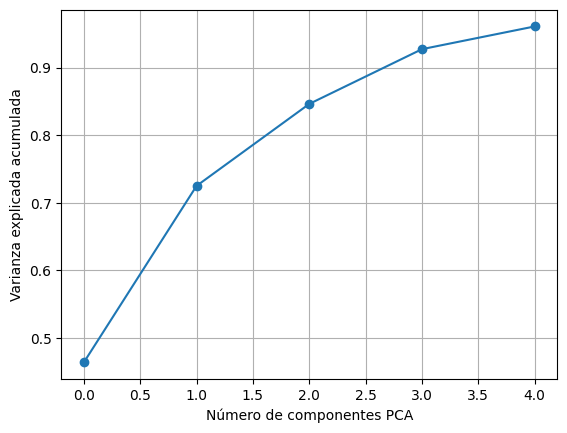

Se entrenaron 8 modelos GMM (uno por clase).
ARI: 0.113
NMI: 0.146


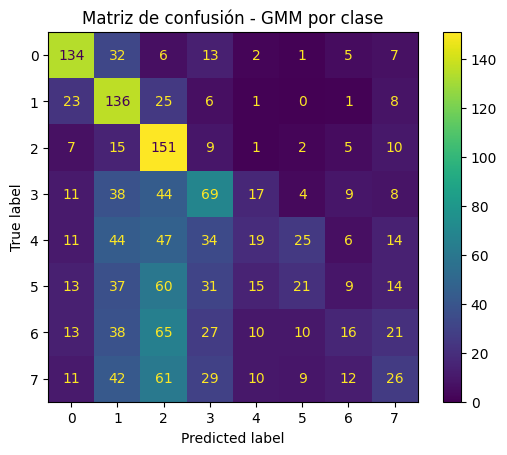

   series_id  gmm_class_pred
0        100               0
1        101               0
2        102               1
3        103               3
4        104               0


In [605]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ===============================
# 1️⃣ Limpieza e imputación
# ===============================
feats_imputed = df_features.fillna(df_features.median())

# ===============================
# 2️⃣ Normalización
# ===============================
scaler = StandardScaler()
X = scaler.fit_transform(feats_imputed.values)

# ===============================
# 3️⃣ PCA (opcional)
# ===============================
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_pca = pca.fit_transform(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Número de componentes PCA')
plt.ylabel('Varianza explicada acumulada')
plt.grid(True)
plt.show()

# ===============================
# 4️⃣ Entrenamiento de un GMM por clase
# ===============================
true = df_all_meta.set_index('series_id').loc[feats_imputed.index, 'target'].to_numpy()


gmms = {}
n_components_per_class = 2  # puedes ajustar este número (1, 2 o 3 suelen ser buenos)
for c in np.unique(true):
    X_class = X_pca[true == c]
    gmm = GaussianMixture(
        n_components=n_components_per_class,
        covariance_type='full',
        random_state=42,
        n_init=5
    )
    gmm.fit(X_class)
    gmms[c] = gmm

print(f"Se entrenaron {len(gmms)} modelos GMM (uno por clase).")

# ===============================
# 5️⃣ Clasificación basada en probabilidad
# ===============================
# Cada fila: muestra; cada columna: log-probabilidad para cada clase
log_probs = np.column_stack([gmms[c].score_samples(X_pca) for c in gmms.keys()])
pred = np.argmax(log_probs, axis=1)

# ===============================
# 6️⃣ Evaluación
# ===============================
ari = adjusted_rand_score(true, pred)
nmi = normalized_mutual_info_score(true, pred)
print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")

cm = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de confusión - GMM por clase")
plt.show()

# ===============================
# 7️⃣ Guardar resultados
# ===============================
label_df = pd.DataFrame({
    'series_id': feats_imputed.index.astype(int),
    'gmm_class_pred': pred
})
label_df.to_csv("gmm_per_class_labels.csv", index=False)
print(label_df.head())


# Random forest

In [606]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [607]:
#Sin PCA
y = df_all_meta['target'].to_numpy()
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

(1600, 11)


RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

Accuracy: 0.375

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.88      0.76        40
           1       0.52      0.82      0.64        40
           2       0.38      0.60      0.47        40
           3       0.33      0.30      0.32        40
           4       0.23      0.15      0.18        40
           5       0.19      0.15      0.17        40
           6       0.09      0.05      0.06        40
           7       0.08      0.05      0.06        40

    accuracy                           0.38       320
   macro avg       0.31      0.37      0.33       320
weighted avg       0.31      0.38      0.33       320


Confusion matrix:


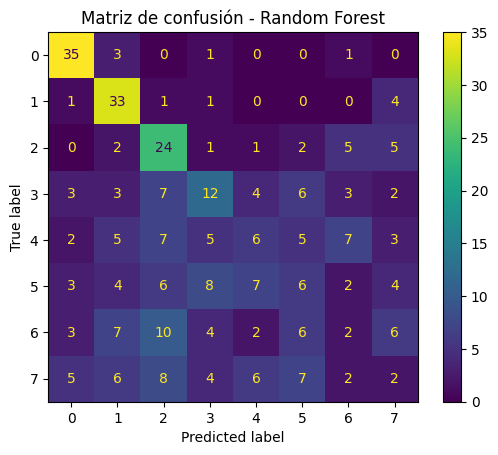

In [608]:
# Predicciones
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)  # probabilidades por clase

# Métricas
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de confusión - Random Forest")
plt.show()

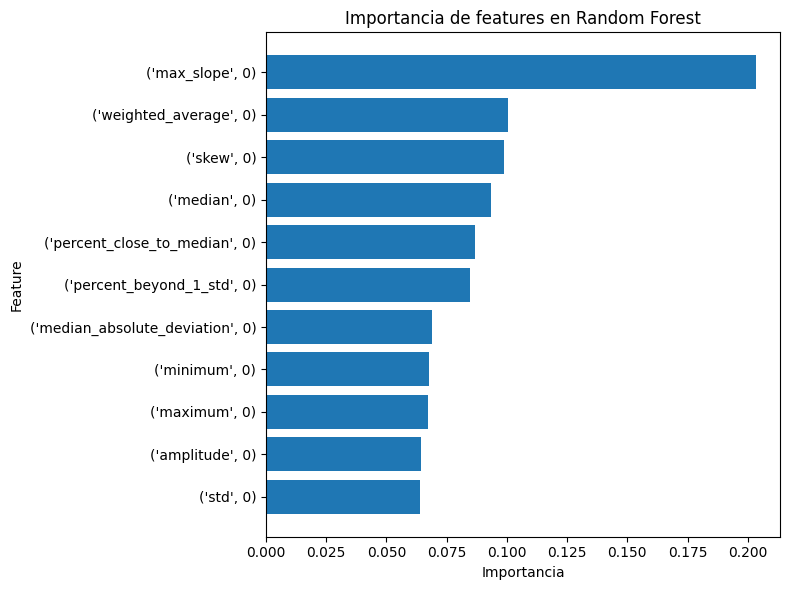

In [609]:
# Obtener importancias y nombres
importances = rf.feature_importances_
feature_names = feats_imputed.columns

# Ordenar de mayor a menor importancia
indices = np.argsort(importances)[::-1]

# Reordenar según la importancia
sorted_importances = importances[indices]
sorted_features = feature_names[indices]

# Gráfico de barras horizontal
plt.figure(figsize=(8, max(6, len(sorted_features) * 0.4)))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_features)), sorted_features, fontsize=10)
plt.gca().invert_yaxis()  # La más importante arriba
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Importancia de features en Random Forest")
plt.tight_layout()
plt.show()


In [610]:
#Usamos X con pca del apartado anterior
X1 = X_pca
y = df_all_meta['target'].to_numpy()
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train1, y_train1)


RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

Accuracy: 0.19375

Classification report:
              precision    recall  f1-score   support

           0       0.35      0.50      0.41        40
           1       0.16      0.17      0.17        40
           2       0.14      0.20      0.16        40
           3       0.34      0.30      0.32        40
           4       0.22      0.23      0.22        40
           5       0.10      0.05      0.07        40
           6       0.00      0.00      0.00        40
           7       0.09      0.10      0.10        40

    accuracy                           0.19       320
   macro avg       0.17      0.19      0.18       320
weighted avg       0.17      0.19      0.18       320


Confusion matrix:


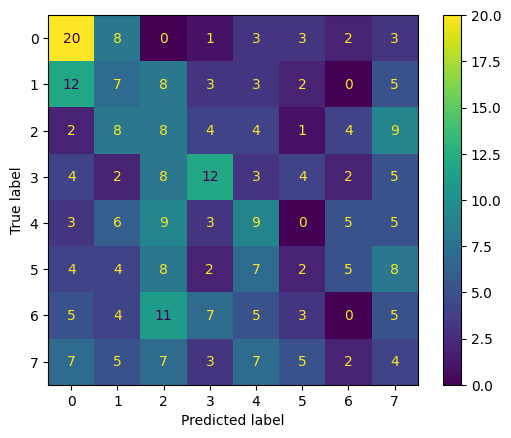

In [611]:
# Predicciones
y_pred1 = rf.predict(X_test1)
y_proba1 = rf.predict_proba(X_test1)  # probabilidades por clase

# Métricas
acc = accuracy_score(y_test1, y_pred1)
print("Accuracy:", acc)

print("\nClassification report:")
print(classification_report(y_test1, y_pred1))

print("\nConfusion matrix:")
cm = confusion_matrix(y_test1, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()



# MLP

In [612]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import random

In [613]:
train_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train)
)

test_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test)
)

In [614]:
print(X_train.shape[1])

11


In [615]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size):

        super().__init__()


        self.mlp_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 8),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.mlp_net(x)

In [616]:
#Early Stopping
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

In [617]:
import time

def NN_classifier(model, train_dataset, val_dataset, epochs, criterion, batch_size, lr, early_stopping_tolerance=15, use_GPU=False):

    if use_GPU:
        model.cuda()

    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)

    #dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    #optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": []
    }

    # Early stopping
    n_epochs_with_no_improvement = 0
    stop = False

    t0 = time.perf_counter()

    for epoch in range(epochs):
        cumulative_train_loss = 0
        cumulative_train_corrects = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            print(f"\rEpoch {epoch + 1}/{epochs} - Batch {i}/{len(train_loader)}", end="")
            if use_GPU:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            # Predicción
            y_predicted = model(x_batch)

            y_batch = y_batch.long().squeeze()

            # Cálculo de loss
            loss = criterion(y_predicted, y_batch)

            # Actualización de parámetros
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cumulative_train_loss += loss.item()

            preds = y_predicted.argmax(dim=1)
            cumulative_train_corrects += (y_batch == preds).sum()

        train_loss = cumulative_train_loss / len(train_loader)
        train_acc = cumulative_train_corrects / len(train_dataset)

        # Evaluación del modelo
        model.eval()
        x_val, y_val = next(iter(val_loader))

        if use_GPU:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        y_val = y_val.long().squeeze()
        loss = criterion(y_predicted, y_val)

        class_prediction = y_predicted.argmax(dim=1)
        val_acc = (y_val == class_prediction).sum() / y_val.shape[0]
        val_loss = loss.item()

        curves["train_acc"].append(train_acc.item())
        curves["val_acc"].append(val_acc.item())
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        print(f" - Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}")

        if early_stopping(val_loss):
            print("Early stopping.")
            break

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    from sklearn.metrics import (
            classification_report,
            accuracy_score,
            precision_score,
            recall_score,
            f1_score,
            precision_recall_fscore_support
        )


    #Imprimir métricas
    try:
        y_true_np = y_val.detach().cpu().numpy().astype(int).ravel()
    except:
        y_true_np = y_val.cpu().numpy().astype(int).ravel()
    try:
        y_pred_np = class_prediction.detach().cpu().numpy().astype(int).ravel()
    except:
        y_pred_np = class_prediction.cpu().numpy().astype(int).ravel()
    # Accuracy
    acc = float(accuracy_score(y_true_np, y_pred_np))
    # Precision/Recall/F1: micro, macro, weighted
    p_macro = float(precision_score(y_true_np, y_pred_np, average="macro", zero_division=0))
    p_micro = float(precision_score(y_true_np, y_pred_np, average="micro", zero_division=0))
    p_weighted = float(precision_score(y_true_np, y_pred_np, average="weighted", zero_division=0))
    r_macro = float(recall_score(y_true_np, y_pred_np, average="macro", zero_division=0))
    r_micro = float(recall_score(y_true_np, y_pred_np, average="micro", zero_division=0))
    r_weighted = float(recall_score(y_true_np, y_pred_np, average="weighted", zero_division=0))
    f1_macro = float(f1_score(y_true_np, y_pred_np, average="macro", zero_division=0))
    f1_micro = float(f1_score(y_true_np, y_pred_np, average="micro", zero_division=0))
    f1_weighted = float(f1_score(y_true_np, y_pred_np, average="weighted", zero_division=0))
    # Per-class metrics (precision, recall, f1, support)

    if y_true_np.size == 0:
        labels = []
    else:
        max_label = int(max(y_true_np.max() if y_true_np.size>0 else 0, y_pred_np.max() if y_pred_np.size>0 else 0))
        labels = list(range(max_label + 1))
    perclass = precision_recall_fscore_support(y_true_np, y_pred_np, labels=labels, zero_division=0)
    per_precisions = perclass[0]
    per_recalls = perclass[1]
    per_f1s = perclass[2]
    per_support = perclass[3]
    # Imprimir resumen compacto
    print("\nValidation metrics summary:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision -> macro: {p_macro:.4f}, micro: {p_micro:.4f}, weighted: {p_weighted:.4f}")
    print(f"  Recall    -> macro: {r_macro:.4f}, micro: {r_micro:.4f}, weighted: {r_weighted:.4f}")
    print(f"  F1-score  -> macro: {f1_macro:.4f}, micro: {f1_micro:.4f}, weighted: {f1_weighted:.4f}")
    # Imprimir tabla por clase
    if len(labels) > 0:
        print("\nPer-class metrics:")
        print("{:>10} {:>10} {:>10} {:>10}".format("Class", "Precision", "Recall", "F1"))
        for idx, lab in enumerate(labels):
            print("{:>10} {:10.4f} {:10.4f} {:10.4f} (support={})".format(
                str(lab), float(per_precisions[idx]), float(per_recalls[idx]), float(per_f1s[idx]), int(per_support[idx])
            ))

    try:
        report = classification_report(y_true_np, y_pred_np, zero_division=0)
        print("\nClassification report (validation):\n", report)
    except Exception as e:
        print("No se pudo generar classification_report:", e)

    model.cpu()

    return curves


In [618]:
epochs = 100
lr = 1e-3
batch_size = 8
early_stopping_tolerance = 15
use_gpu = False

criterion = nn.CrossEntropyLoss()

input_size = X_train.shape[1]
hidden_size = 10
model = MLPModel(input_size, hidden_size=hidden_size)

curves = NN_classifier(model, train_dataset, test_dataset, epochs, criterion, batch_size, lr, early_stopping_tolerance, use_gpu)


Epoch 1/100 - Batch 159/160 - Train loss: 2.0795948818325996, Train acc: 0.11562500149011612, Val loss: 2.079138994216919, Val acc: 0.11249999701976776
Epoch 2/100 - Batch 159/160 - Train loss: 2.078549401462078, Train acc: 0.12890625, Val loss: 2.077709197998047, Val acc: 0.13750000298023224
Epoch 3/100 - Batch 159/160 - Train loss: 2.07566270083189, Train acc: 0.15703125298023224, Val loss: 2.0715975761413574, Val acc: 0.15937499701976776
Epoch 4/100 - Batch 159/160 - Train loss: 2.0677719309926035, Train acc: 0.15546874701976776, Val loss: 2.0614757537841797, Val acc: 0.14687499403953552
Epoch 5/100 - Batch 159/160 - Train loss: 2.053182140737772, Train acc: 0.16015625, Val loss: 2.0501015186309814, Val acc: 0.15312500298023224
Epoch 6/100 - Batch 159/160 - Train loss: 2.039655814319849, Train acc: 0.16953125596046448, Val loss: 2.04341721534729, Val acc: 0.15312500298023224
Epoch 7/100 - Batch 159/160 - Train loss: 2.030453400313854, Train acc: 0.18281249701976776, Val loss: 2.0395

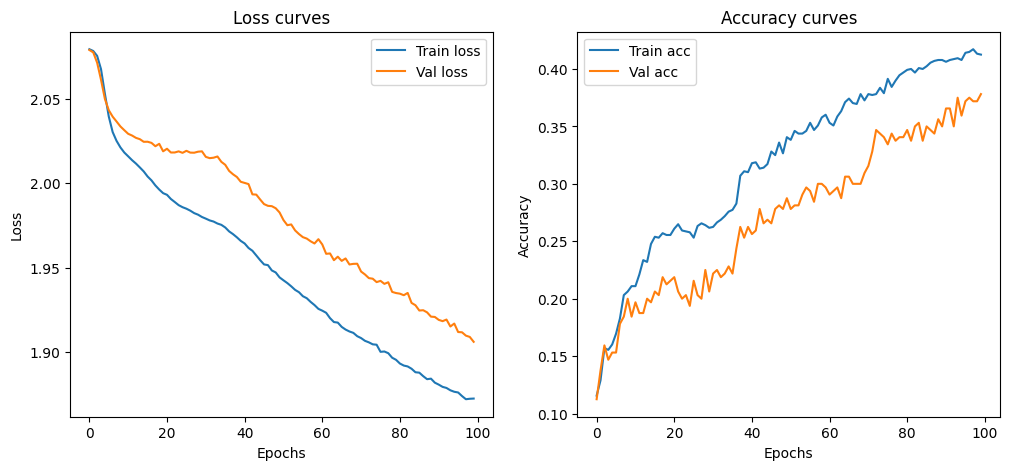

In [619]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(curves["train_loss"], label="Train loss")
plt.plot(curves["val_loss"], label="Val loss")
plt.title("Loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(curves["train_acc"], label="Train acc")
plt.plot(curves["val_acc"], label="Val acc")
plt.title("Accuracy curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [620]:
def plot_cm(model, dataset, batch_size=128, class_names=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    # loader
    if isinstance(dataset, torch.utils.data.DataLoader):
        loader = dataset
    else:
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    model.eval()

    y_trues, y_preds = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1).cpu().numpy()


            if y.dim() == 2 and y.size(1) > 1:
                y = y.argmax(dim=1)
            y = y.cpu().numpy()

            y_trues.append(y)
            y_preds.append(preds)

    y_true = np.concatenate(y_trues, axis=0)
    y_pred = np.concatenate(y_preds, axis=0)


    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=(class_names if class_names is not None else None))
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, values_format='d', cmap='viridis')
    plt.title("Matriz de confusión - CNN")
    plt.show()

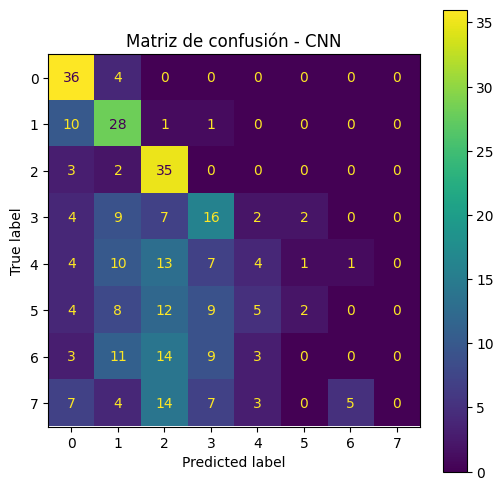

In [621]:
#Matriz de confusión
cm = plot_cm(model, test_dataset, batch_size=32, class_names=['0','1','2','3','4','5','6','7'], device='cuda' if use_gpu else 'cpu')


# CNN

In [622]:
class CNNFeatures(nn.Module):

    def __init__(self,
                 n_features,
                 n_classes,
                 in_channels=1,
                 channels=(16, 32),
                 kernel_sizes=(3, 3),
                 pool_kernel=2,
                 dropout=0.2):
        super().__init__()
        assert len(channels) == len(kernel_sizes), "channels y kernel_sizes deben tener el mismo largo"
        self.n_features = n_features


        self.in_channels = in_channels

        blocks = []
        curr_in = in_channels
        for out_ch, k in zip(channels, kernel_sizes):

            padding = k // 2
            blocks += [
                nn.Conv1d(curr_in, out_ch, kernel_size=k, padding="same"),
                nn.BatchNorm1d(out_ch),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=pool_kernel, stride=pool_kernel)
            ]
            curr_in = out_ch

        self.encoder = nn.Sequential(*blocks)


        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Clasificador final
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(curr_in, n_classes),
            nn.Softmax(dim=1)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):

        if x.dim() == 2:

            x = x.unsqueeze(1)
        else:

            pass


        x = self.encoder(x)
        x = self.global_pool(x)
        out = self.classifier(x)
        return out


In [664]:
n_features = 11
n_classes = 8

model = CNNFeatures(n_features=n_features,
                    n_classes=n_classes,
                    in_channels=1,
                    channels=(16, 32),
                    kernel_sizes=(5, 3),
                    pool_kernel=2,
                    dropout=0.3)

criterion = torch.nn.CrossEntropyLoss()
curves = NN_classifier(model, train_dataset, test_dataset,
                        epochs=100,
                        criterion=criterion,
                        batch_size=8,
                        lr=1e-3,
                        early_stopping_tolerance=15,
                        use_GPU=False)


Epoch 1/100 - Batch 159/160 - Train loss: 2.087724073976278, Train acc: 0.12812499701976776, Val loss: 2.075824022293091, Val acc: 0.14374999701976776
Epoch 2/100 - Batch 159/160 - Train loss: 2.0812934190034866, Train acc: 0.13671875, Val loss: 2.0663015842437744, Val acc: 0.16249999403953552
Epoch 3/100 - Batch 159/160 - Train loss: 2.070182368159294, Train acc: 0.15625, Val loss: 2.0640883445739746, Val acc: 0.14687499403953552
Epoch 4/100 - Batch 159/160 - Train loss: 2.0556560188531874, Train acc: 0.18046875298023224, Val loss: 2.056100606918335, Val acc: 0.15312500298023224
Epoch 5/100 - Batch 159/160 - Train loss: 2.048206002265215, Train acc: 0.19374999403953552, Val loss: 2.05664324760437, Val acc: 0.19062499701976776
Epoch 6/100 - Batch 159/160 - Train loss: 2.043059404939413, Train acc: 0.19765624403953552, Val loss: 2.0557477474212646, Val acc: 0.17499999701976776
Epoch 7/100 - Batch 159/160 - Train loss: 2.039268330484629, Train acc: 0.21640625596046448, Val loss: 2.054731

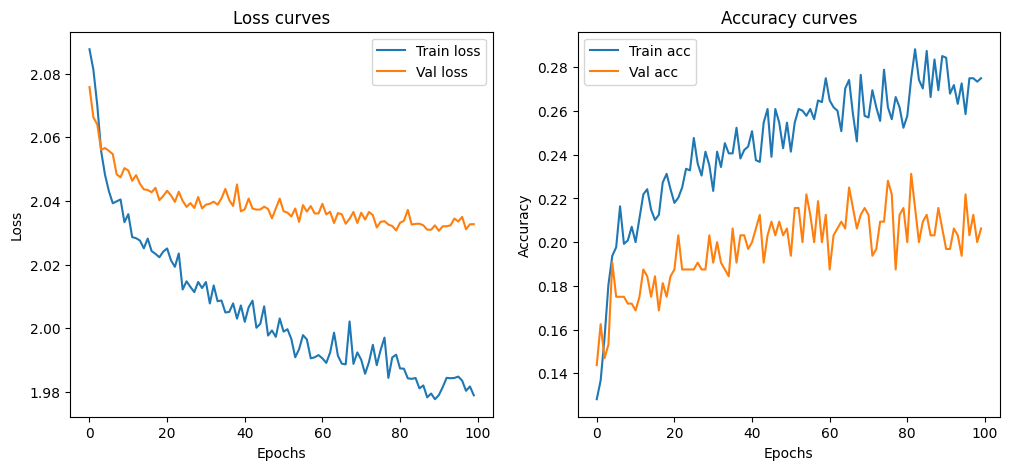

In [665]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(curves["train_loss"], label="Train loss")
plt.plot(curves["val_loss"], label="Val loss")
plt.title("Loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(curves["train_acc"], label="Train acc")
plt.plot(curves["val_acc"], label="Val acc")
plt.title("Accuracy curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

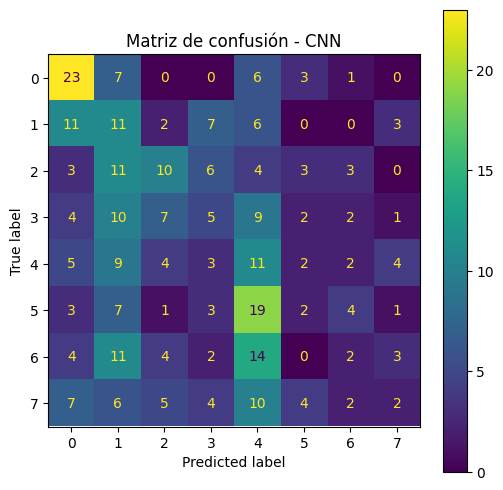

In [666]:
#Matriz de confusión
cm = plot_cm(model, test_dataset, batch_size=32, class_names=['0','1','2','3', '4', '5', '6', '7'], device='cuda' if use_gpu else 'cpu')